In [ ]:
import os
import zipfile
import requests
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Set up Roboflow API details
ROBOFLOW_API_KEY = "px6xNHEPXTTsWimpGefG"
PROJECT_NAME = "circuit_component_values-g6af5"
MODEL_VERSION = "1"

# Paths
ZIP_FILE_PATH = "/content/Circuit_Diagrams.zip"
EXTRACT_FOLDER = "/content/extracted_images"
CSV_FILE_PATH = "/content/circuit_power_requirements new.csv"

# Define all valid component values to detect
COMPONENT_VALUES = {
    'resistor': ['1ohm', '2ohm', '3ohm'],
    'capacitor': ['1F', '2F', '3F'],
    'inductor': ['1H', '2H', '3H']
}

# Extract ZIP file
os.makedirs(EXTRACT_FOLDER, exist_ok=True)
with zipfile.ZipFile(ZIP_FILE_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_FOLDER)

# Load and prepare CSV data
df = pd.read_csv(CSV_FILE_PATH)
df.columns = df.columns.str.strip().str.lower()

# Map CSV columns to standardized names
column_mapping = {
    'resistor (ω)': 'resistor',
    'capacitor (f)': 'capacitor',
    'inductor (h)': 'inductor'
}
df = df.rename(columns=column_mapping)

# Get list of extracted images
image_files = [os.path.join(EXTRACT_FOLDER, f) for f in os.listdir(EXTRACT_FOLDER)
              if f.endswith((".png", ".jpg", ".jpeg"))]

def process_image(image_path):
    """Process image through Roboflow API and count specific component values"""
    upload_url = f"https://detect.roboflow.com/{PROJECT_NAME}/{MODEL_VERSION}?api_key={ROBOFLOW_API_KEY}"
    with open(image_path, "rb") as f:
        response = requests.post(upload_url, files={"file": f})

    if response.status_code != 200:
        print(f"Error processing {image_path}: {response.text}")
        return None

    result = response.json()
    detections = result.get("predictions", [])

    # Initialize component counts with only specific values
    component_counts = {
        'resistor': {value: 0 for value in COMPONENT_VALUES['resistor']},
        'capacitor': {value: 0 for value in COMPONENT_VALUES['capacitor']},
        'inductor': {value: 0 for value in COMPONENT_VALUES['inductor']}
    }

    for detection in detections:
        label = detection.get("class", "").lower()

        # Check for each component type and value
        for comp_type, values in COMPONENT_VALUES.items():
            for value in values:
                if value.lower() in label:
                    component_counts[comp_type][value] += 1
                    break  # Move to next detection after first match

    # Display processed image
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Processed: {os.path.basename(image_path)}")
        plt.show()

    # Print detection results
    print(f"\nDETECTED COMPONENTS in {os.path.basename(image_path)}:")
    for comp_type, values in component_counts.items():
        detected = [f"{v}:{c}" for v, c in values.items() if c > 0]
        if detected:
            print(f"- {comp_type.capitalize()}: {', '.join(detected)}")

    return component_counts

# Process all images and collect results
results = []
for image in image_files:
    counts = process_image(image)
    if counts:
        results.append(counts)

# Create flattened results DataFrame
flat_data = []
for result in results:
    flat_result = {}
    for comp_type, values in result.items():
        for value, count in values.items():
            flat_result[f"{comp_type}_{value}"] = count
    flat_data.append(flat_result)

df_results = pd.DataFrame(flat_data)

# Save results
output_csv = "/content/detected_circuit_components.csv"
df_results.to_csv(output_csv, index=False)
print(f"Component detection results saved to: {output_csv}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Set up paths and API
ZIP_FILE_PATH = "/content/Circuit_Diagrams.zip"
EXTRACT_FOLDER = "/content/extracted_images"
POWER_CSV_PATH = "/content/circuit_power_requirements new.csv"
OUTPUT_CSV_PATH = "/content/detected_power_requirements.csv"
ROBOFLOW_API_KEY = "px6xNHEPXTTsWimpGefG"
PROJECT_NAME = "circuit_component_values-g6af5"
MODEL_VERSION = "1"

# Extract images
os.makedirs(EXTRACT_FOLDER, exist_ok=True)
with zipfile.ZipFile(ZIP_FILE_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_FOLDER)

# Load and process power requirements CSV
power_df = pd.read_csv(POWER_CSV_PATH)

# Standardize column names (handling Ω symbol)
power_df.columns = power_df.columns.str.strip()
power_df = power_df.rename(columns={
    'Resistor (Ω)': 'Resistor (Ω)',
    'Capacitor (F)': 'Capacitor (F)',
    'Inductor (H)': 'Inductor (H)',
    'Power Requirement': 'Power Requirement'
})

# Verify required columns
required_columns = ['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)', 'Power Requirement']
if not all(col in power_df.columns for col in required_columns):
    missing = set(required_columns) - set(power_df.columns)
    raise KeyError(f"Missing columns: {missing}")

# Extract numeric power values
power_df[['Power_W', 'Voltage_V']] = power_df['Power Requirement'].str.extract(r'([\d.]+)W,\s*([\d.]+)V').astype(float)

# Create interpolation functions
interp_funcs = {'power': {}, 'voltage': {}}
for component in ['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)']:
    sorted_df = power_df.sort_values(component)
    interp_funcs['power'][component] = interp1d(
        sorted_df[component], sorted_df['Power_W'],
        kind='linear', fill_value='extrapolate'
    )
    interp_funcs['voltage'][component] = interp1d(
        sorted_df[component], sorted_df['Voltage_V'],
        kind='linear', fill_value='extrapolate'
    )

# Process images through Roboflow
def process_image(image_path):
    upload_url = f"https://detect.roboflow.com/{PROJECT_NAME}/{MODEL_VERSION}?api_key={ROBOFLOW_API_KEY}"
    with open(image_path, "rb") as f:
        response = requests.post(upload_url, files={"file": f})

    if response.status_code != 200:
        print(f"Error processing {image_path}: {response.text}")
        return None

    detections = response.json().get("predictions", [])
    counts = {'Resistor (Ω)': 0, 'Capacitor (F)': 0, 'Inductor (H)': 0}

    for d in detections:
        label = d.get("class", "").lower()
        if 'resistor' in label or 'ohm' in label:
            counts['Resistor (Ω)'] += 1
        elif 'capacitor' in label:
            counts['Capacitor (F)'] += 1
        elif 'inductor' in label:
            counts['Inductor (H)'] += 1

    return counts

# Process all images
results = []
for img in os.listdir(EXTRACT_FOLDER):
    if img.lower().endswith(('.png', '.jpg', '.jpeg')):
        res = process_image(os.path.join(EXTRACT_FOLDER, img))
        if res:
            results.append(res)

# Create results DataFrame
df_results = pd.DataFrame(results)

# Calculate power requirements in original format
def calculate_power(row):
    power_ests = []
    voltage_ests = []

    for comp in ['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)']:
        if row[comp] > 0:
            try:
                power_ests.append(interp_funcs['power'][comp](row[comp]))
                voltage_ests.append(interp_funcs['voltage'][comp](row[comp]))
            except:
                continue

    avg_power = np.mean(power_ests) if power_ests else 0
    avg_voltage = np.mean(voltage_ests) if voltage_ests else 0
    return f"{avg_power:.1f}W, {avg_voltage:.1f}V"

df_results['Power Requirement'] = df_results.apply(calculate_power, axis=1)

# Select and reorder columns to match original CSV
output_columns = ['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)', 'Power Requirement']
df_output = df_results[output_columns]

# Configure pandas to display all rows without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Save and display results
df_output.to_csv(OUTPUT_CSV_PATH, index=False)

print("Complete Circuit Analysis Results:")
print(df_output.to_string())
print(f"\nResults saved to {OUTPUT_CSV_PATH}")

# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

Complete Circuit Analysis Results:
     Resistor (Ω)  Capacitor (F)  Inductor (H) Power Requirement
0              10              0             0        2.8W, 5.3V
1               2              1             1        0.6W, 1.2V
2               4              0             0        1.0W, 1.9V
3               1              0             1        0.6W, 1.1V
4               2              0             2        0.8W, 1.7V
5               4              0             0        1.0W, 1.9V
6               6              1             2        1.1W, 2.1V
7               2              0             0        0.5W, 1.0V
8               6              1             1        1.0W, 1.9V
9               2              0             0        0.5W, 1.0V
10              2              0             2        0.8W, 1.7V
11              2              0             2        0.8W, 1.7V
12              8              0             0        2.2W, 4.1V
13              4              0             0        1

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.8264 - mae: 0.7112 - val_loss: 0.3129 - val_mae: 0.4001
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3160 - mae: 0.4187 - val_loss: 0.1321 - val_mae: 0.2780
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1426 - mae: 0.2863 - val_loss: 0.0567 - val_mae: 0.1603
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0821 - mae: 0.2156 - val_loss: 0.0414 - val_mae: 0.1605
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0616 - mae: 0.1961 - val_loss: 0.0322 - val_mae: 0.1476
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0604 - mae: 0.1929 - val_loss: 0.0244 - val_mae: 0.1205
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0582 - mae: 0.1810 - val_loss: 0.0233 - val_mae: 0.1019
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0707 - mae: 0.1976 - val_loss: 0.0220 - val_mae: 0.1100
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0522 - mae: 

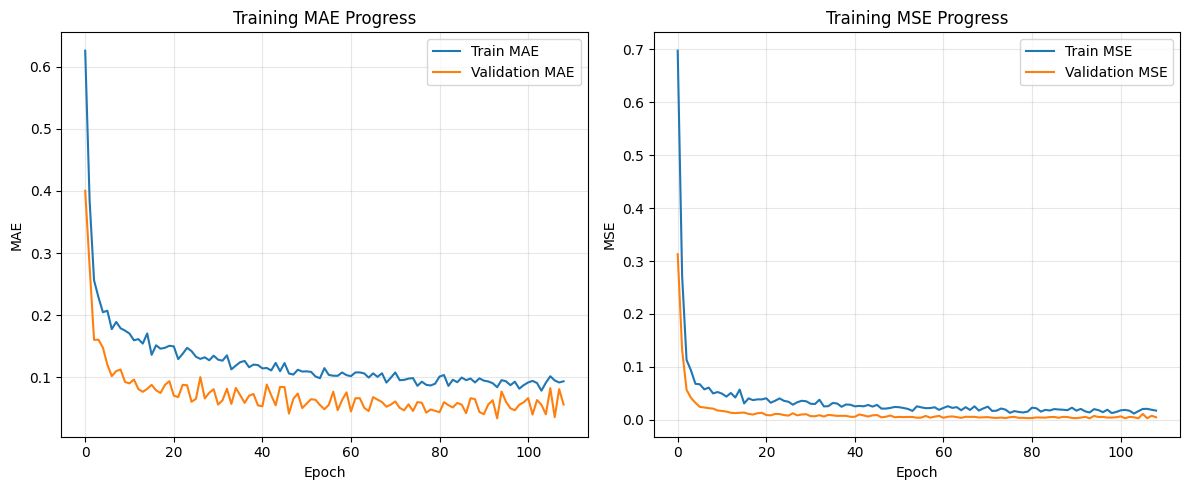

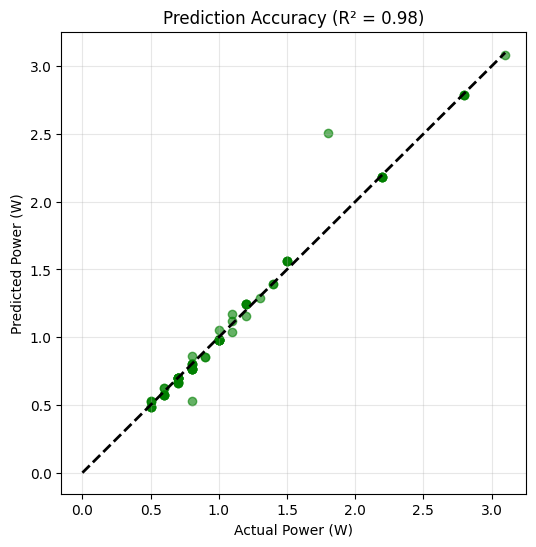

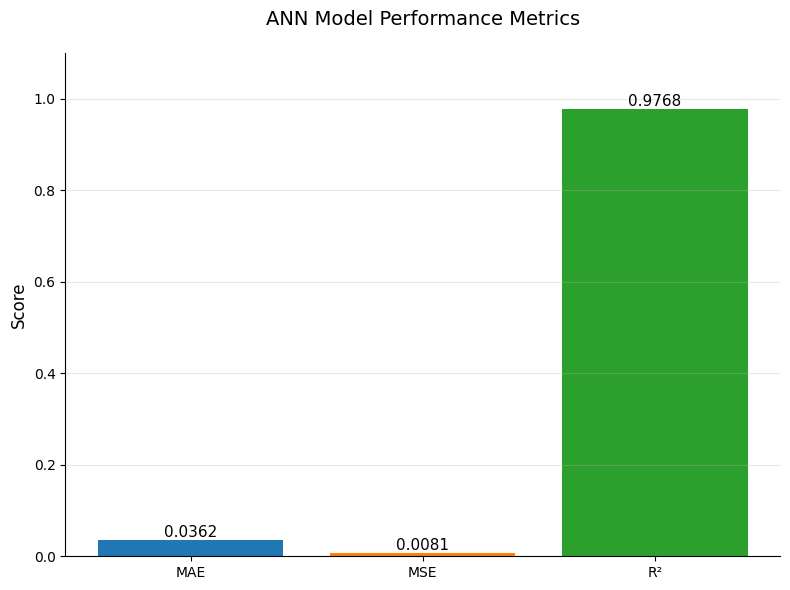

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Load and preprocess dataset
df = pd.read_csv('detected_power_requirements final.csv')

# Extract power values from strings like "2.8W, 5.3V"
df['Power (W)'] = df['Power Requirement'].str.extract('(\d+\.\d+)W')[0].astype(float)

# Prepare features and target
X = df[['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)']]
y = df['Power (W)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_model()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Model training
history = model.fit(X_train_scaled, y_train,
                   epochs=200,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[early_stop],
                   verbose=1)

# Predictions
y_pred = model.predict(X_test_scaled, verbose=0)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Training Progress Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE Progress')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Training MSE Progress')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Actual vs Predicted Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Power (W)')
plt.ylabel('Predicted Power (W)')
plt.title(f'Prediction Accuracy (R² = {r2:.2f})')
plt.grid(True, alpha=0.3)
plt.show()

# Metrics Comparison Visualization (Matching RNN style)
metrics = ['MAE', 'MSE', 'R²']
values = [mae, mse, r2]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('ANN Model Performance Metrics', fontsize=14, pad=20)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.1)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom',
             fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Save model
model.save('circuit_power_ann_model.keras')

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.4956 - mae: 0.9730 - val_loss: 0.2897 - val_mae: 0.4771
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2760 - mae: 0.4448 - val_loss: 0.0503 - val_mae: 0.1737
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1312 - mae: 0.2894 - val_loss: 0.0492 - val_mae: 0.1666
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1449 - mae: 0.2789 - val_loss: 0.0219 - val_mae: 0.1134
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1016 - mae: 0.2422 - val_loss: 0.0206 - val_mae: 0.1055
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0869 - mae: 0.2233 - val_loss: 0.0292 - val_mae: 0.1244
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0834 - mae: 0.2187 - val_loss: 0.0239 - val_mae: 0.1120
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1073 - mae: 0.2416 - val_loss: 0.0189 - val_mae: 0.1031
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

Final Evaluation Metrics (RNN):
MAE: 0.0604
MSE: 0.0104
R²: 0.9704


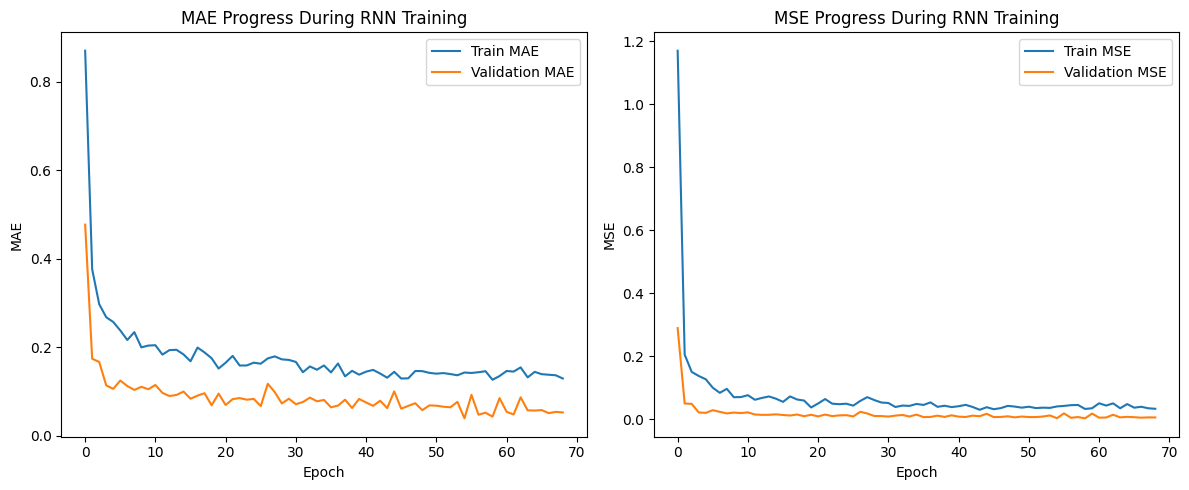

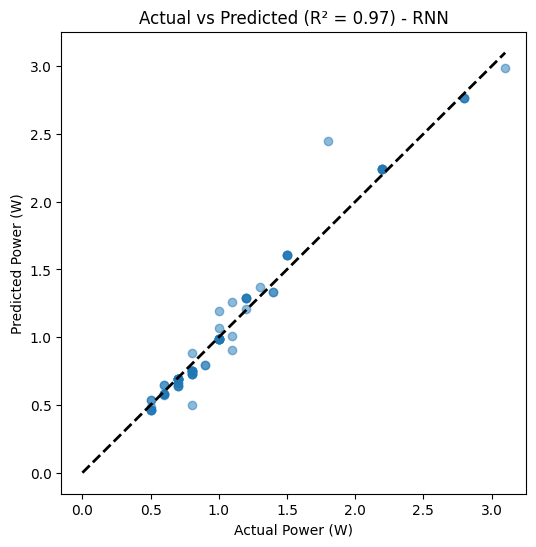

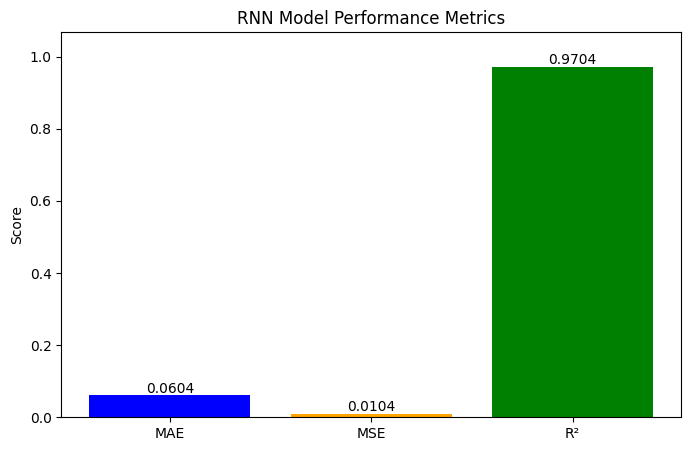

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the dataset
df = pd.read_csv('detected_power_requirements final.csv')

# Extract power values (remove 'W' and convert to float)
df['Power (W)'] = df['Power Requirement'].str.extract('(\d+\.\d+)W')[0].astype(float)

# Prepare features and target
X = df[['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)']]
y = df['Power (W)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for RNN (samples, timesteps, features)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# RNN Model
def create_rnn_model():
    model = Sequential([
        SimpleRNN(64, activation='tanh', input_shape=(X_train_rnn.shape[1], 1)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = create_rnn_model()

# Model training
history = model.fit(X_train_rnn, y_train,
                    epochs=150,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

# Predictions
y_pred = model.predict(X_test_rnn)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Evaluation Metrics (RNN):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# Visualization 1: Training Progress
plt.figure(figsize=(12, 5))

# MAE Progress
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Progress During RNN Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# MSE Progress
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE Progress During RNN Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Visualization 2: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Power (W)')
plt.ylabel('Predicted Power (W)')
plt.title(f'Actual vs Predicted (R² = {r2:.2f}) - RNN')
plt.show()

# Visualization 3: Metric Comparison
metrics = ['MAE', 'MSE', 'R²']
values = [mae, mse, r2]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green'])

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.title('RNN Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, max(values) * 1.1)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Load and preprocess dataset
df = pd.read_csv('detected_power_requirements final.csv')

# Extract power values from strings like "2.8W, 5.3V"
df['Power (W)'] = df['Power Requirement'].str.extract('(\d+\.\d+)W')[0].astype(float)

# Prepare features and target
X = df[['Resistor (Ω)', 'Capacitor (F)', 'Inductor (H)']]
y = df['Power (W)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to maintain feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# ANN Model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

# Create model with fixed input shape to prevent retracing
model = create_model()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss',
                          patience=15,
                          restore_best_weights=True,
                          verbose=0)

# Model training with fixed batch size to prevent retracing
history = model.fit(X_train_scaled, y_train,
                   epochs=200,
                   batch_size=32,  # Fixed batch size
                   validation_split=0.2,
                   callbacks=[early_stop],
                   verbose=1)

# Predictions with fixed batch size
y_pred = model.predict(X_test_scaled, batch_size=32, verbose=0)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Visualization 1: Training Progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training MAE Progress')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Training MSE Progress')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization 2: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Power (W)')
plt.ylabel('Predicted Power (W)')
plt.title(f'Prediction Accuracy (R² = {r2:.2f})')
plt.grid(True, alpha=0.3)
plt.show()

# Save model
model.save('circuit_power_model.keras')

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'detected_power_requirements final.csv'

In [ ]:
Resistor,Capacitor,Inductor,Power Requirement (mW)
2,1,0,500
5,3,2,1200
10,5,5,2800
20,10,7,5500
50,25,15,12000

SyntaxError: invalid syntax (<ipython-input-1-de6142e2adc2>, line 1)